# import packages

In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tqdm
import scanpy as sc
import anndata as ad

import sys
sys.path.append('./')
from CellCruise import *

import warnings
warnings.filterwarnings("ignore")

# Read data and preprocess

In [2]:
adata = sc.AnnData(
    pd.read_csv('./data/count.csv', index_col=0))
adata.obs['celltype'] = pd.read_csv('./data/celltype.csv', index_col=0).loc[adata.obs_names, ]

adata.layers['raw_count'] = adata.X.copy()
sc.pp.normalize_total(adata)
adata.layers['normalized_count'] = adata.X.copy()
sc.pp.log1p(adata)
adata.layers['log1p_count'] = adata.X.copy()

adata = perform_PCA(adata)
adata = knn_imputation(adata, n_pca_dims=30)

# Option 1: You can use the following code to obtain a visualization of dimensionality reduction:

In [3]:
# sc.pp.highly_variable_genes(adata, n_top_genes=2000)
# sc.pp.pca(adata, use_highly_variable=True)
# sc.pp.neighbors(adata)
# sc.tl.tsne(adata)
# sc.tl.umap(adata)
# sc.pl.umap(adata, color='celltype')

# Option 2: To reproduce the results, we will use the previously reduced UMAP coordinates

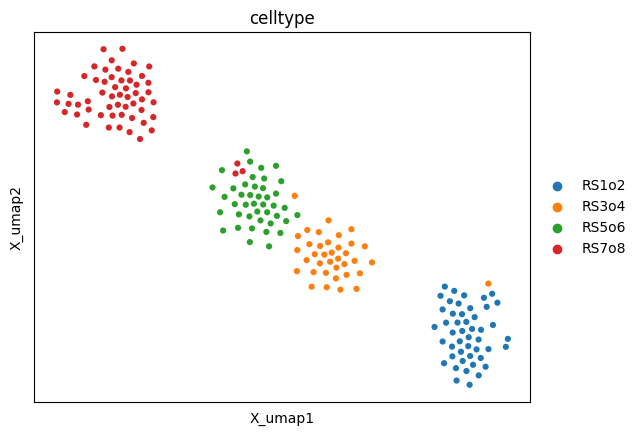

In [4]:
embedding_name = 'X_umap'
cluster_name = 'celltype'

adata.obsm[embedding_name] = pd.read_csv('./data/umap.csv', index_col=0).loc[adata.obs_names, ].values

size = 80
sc.pl.embedding(adata, basis=embedding_name, color=cluster_name, s=size)

# Read deltaX，calculate the correlation, and plot the differentiation direction

In [5]:
# read the path where the deltaX calculated from the probability graph is stored:
deltaX_path = './deltaX/deltax*.csv'
selected_files = glob.glob(deltaX_path)

In [6]:
# obtain TF and TG based on deltaX
TG = []
for i, data_temp in enumerate(tqdm.tqdm(selected_files)):
    detlaX = pd.read_csv(data_temp, index_col=1)
    TG = TG + detlaX.index.to_list()
    if i == 0:
        TF = set(detlaX.columns)
    else:
        TF = set(detlaX.columns).intersection(TF)
        
TF = list(set(TF).intersection(adata.var_names))
TG = list(set(TG).intersection(adata.var_names))

100%|██████████| 4/4 [00:00<00:00, 309.11it/s]


In [7]:
# set the TF to be knocked out 
gois = ['Rfx2', 'Crem', 'Hoxa4']

100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


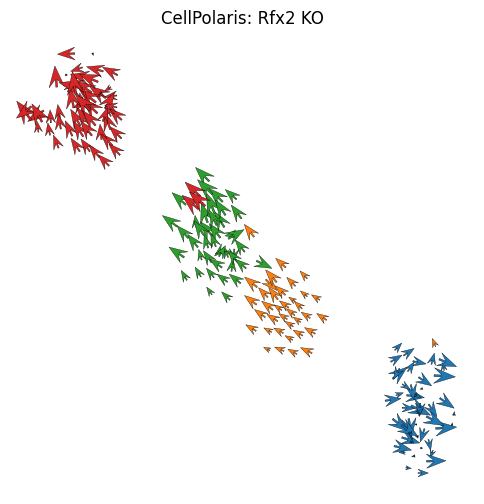

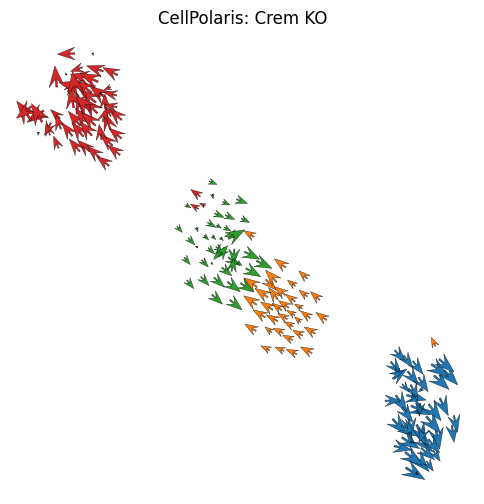

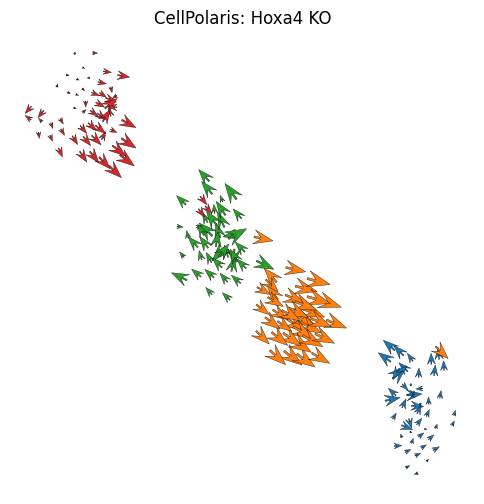

In [8]:
# plot the differentiation direction
for i, goi in enumerate(tqdm.tqdm(gois)):
    
    adata = get_deltaX(adata, deltaX_path=deltaX_path, goi=goi)
    
    estimate_transition_prob(adata, embedding_name=embedding_name, 
                             goi=goi, n_neighbors=100,
                             n_jobs=4, threads=8)
    
    calculate_embedding_shift(adata, embedding_name=embedding_name, sigma_corr=0.05)

    col_dict = get_clustercolor_from_anndata(adata,
                                             cluster_name=cluster_name,
                                             return_as="dict")
    
    colorandum = np.array([col_dict[i] for i in adata.obs[cluster_name]])

    fig, ax = plt.subplots(1, 1, figsize=[6, 6])
    
    scale_try = plot_quiver(adata, colorandum=colorandum, embedding_name=embedding_name, scale=20,
                            ax=ax)
    
    if not os.path.exists(f"./results"):
        os.makedirs(f"./results")  
              
    ax.set_title(f"CellPolaris: {goi} KO")
    
    fig.savefig(f"./results/{goi}.png", dpi=600, bbox_inches='tight')     
    fig.savefig(f"./results/{goi}.pdf", dpi=600, bbox_inches='tight')

# identify important TFs along the differentiation path

In [9]:
# set the differentiation path
trajectorys = [
        ['RS1o2', 'RS3o4', 'RS5o6', 'RS7o8']
]

# Read gene lengths for synthesize pseudo-bulk according to clusters
database_path = './database/'

# mouse or human
species = 'mouse'

In [10]:
# Record all TF score
inner_product_TF_all = pd.DataFrame()

for goi in tqdm.tqdm(TF):
    # calculate the cosine similarity between every two adjacent clusters
    inner_product_TF = identifying_important_TFs(adata, goi=goi, deltaX_path=deltaX_path, 
                                                 trajectorys=trajectorys, species=species, 
                                                 cluster_name=cluster_name, TG=TG, database_path=database_path)
    if inner_product_TF_all.shape == (0, 0):
        inner_product_TF_all = inner_product_TF
    else:
        inner_product_TF_all = pd.concat([inner_product_TF_all, inner_product_TF], axis=1)                                    

100%|██████████| 12/12 [00:05<00:00,  2.04it/s]


In [12]:
inner_product_TF_all = inner_product_TF_all.T
inner_product_TF_all

,RS1o2->RS3o4,RS3o4->RS5o6,RS5o6->RS7o8
Mxd4,0.682616,0.969976,1.000000
Creb3,1.000000,1.000000,1.000000
Creb3l4,-0.453665,-0.769498,-0.191408
Rfx4,0.223817,-0.515738,-0.208943
Rfx2,0.242843,0.193354,0.530835
Hoxa4,0.697987,-0.118335,0.248332
Atf1,0.043516,-0.068418,0.140268
Zbtb3,0.409492,0.991820,-0.842870
Mesp1,0.820598,0.789861,-0.253517
Rfx5,0.168249,0.019611,0.698099


In [14]:
# Calculating the TOP 10TF for each stage
result = pd.DataFrame()
for i in inner_product_TF_all.columns:
    col1_min_10 = pd.DataFrame(inner_product_TF_all[i].nsmallest(10).index, columns=[i])
    if result.shape == (0, 0):
        result = col1_min_10
    else:        
        result = pd.concat([result, col1_min_10], axis=1)
result

,RS1o2->RS3o4,RS3o4->RS5o6,RS5o6->RS7o8
0,Creb3l4,Creb3l4,Zbtb3
1,Smc3,Rfx4,Mesp1
2,Crem,Hoxa4,Rfx4
3,Atf1,Atf1,Creb3l4
4,Rfx5,Rfx5,Crem
5,Rfx4,Rfx2,Atf1
6,Rfx2,Crem,Hoxa4
7,Zbtb3,Mesp1,Rfx2
8,Mxd4,Smc3,Rfx5
9,Hoxa4,Mxd4,Smc3
